In [660]:
%load_ext autoreload
%autoreload 2

from loader import Data, load_data_from_json
from generator import generate_random
from ploter import Ploter
import numpy as np

import pandas as pd
from model import Model
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [661]:
# data: Data = load_data_from_json("../data/toy_instance.json")
data: Data = generate_random(5, 3, 3, 3)

In [662]:
print(data)

Data(N=5, E=3, Q=3, P=3, _qualifications=[[2, 0], [1, 0], [1, 2]], _conges=[[4, 1], [], []], _duree=[[0, 4, 3], [3, 0, 0], [5, 5, 1]], _gain=[33, 1, 85], _due_date=[1, 6, 6], _penalty=[50, 13, 86], _employees_names=['employee#0', 'employee#1', 'employee#2'], _qualifications_names=['qual#0', 'qual#1', 'qual#2'], _projects_names=['project#0', 'project#1', 'project#2'], M=10000000.0)


In [663]:
m = Model(data)

In [664]:
m.constraint_cant_work_more_than_needed()
m.constraint_cant_work_on_days_off()
m.constraint_no_qual_work()
m.constraint_one_project_per_day()

In [665]:
m.determine_affecte()
m.determine_debute()
m.determine_realise()

In [666]:
m.objective_max_gain()

In [667]:
m.update()

In [668]:
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 129 rows, 177 columns and 1320 nonzeros
Model fingerprint: 0x6f7b0840
Variable types: 0 continuous, 177 integer (177 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective -150.0000000
Presolve removed 105 rows and 120 columns
Presolve time: 0.00s
Presolved: 24 rows, 57 columns, 187 nonzeros
Variable types: 0 continuous, 57 integer (57 binary)

Root relaxation: objective 2.936364e+01, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.36364  

In [669]:
def get_completion_day(p):
    for j in range(m.data.N):
        if m.realise(p, j).X == 1:
            return j - 1
    return None


def get_work(p):
    df = pd.DataFrame()
    for e in range(m.data.E):
        work_done = []
        for j in range(m.data.N):
            work = []
            for q in range(m.data.Q):
                work.append(m.projet(e, j, p, q).X)
            has_worked = 1 in work
            if not has_worked:
                if j in m.data.conges(e):
                    work_done.append("X")
                else:
                    work_done.append(" ")
            else:
                work = np.argmax(work)
                work = m.data.qualification_name(work)
                work_done.append(work)
        df[m.data.employee_name(e)] = work_done

    due = []
    for j in range(m.data.N):
        if j == m.data.due_date(p):
            due.append("X")
        else:
            due.append("")

    completed = []
    completion_day = get_completion_day(p)
    for j in range(m.data.N):
        if j == completion_day:
            completed.append("X")
        else:
            completed.append("")

    df["Due_Date"] = due
    df["Completed"] = completed

    return df

In [670]:
for p in range(m.data.P):
    qualis = []
    for q in range(m.data.Q):
        qualis.append((m.data.qualification_name(q), m.data.duree(p, q)))
    print("Work on", m.data.projet_name(p), qualis)
    print(get_work(p))
    completion_day = get_completion_day(p)
    if completion_day != None:
        print("Project completed, gained", m.data.gain(p))
        if m.data.due_date(p) < completion_day:
            print("Project late", completion_day - m.data.due_date(p), "day, lost", m.data.penalite(p, completion_day))
        print("Total gain", m.data.gain(p) - m.data.penalite(p, completion_day))
    else:
        print("Project not completed")
        print("Project late", m.data.N - 1 - m.data.due_date(p), "day, lost", m.data.penalite(p, m.data.N - 1))
        print("Total gain", -m.data.penalite(p, m.data.N - 1))

    print()

print(m.model.ObjVal)

Work on project#0 [('qual#0', 0), ('qual#1', 4), ('qual#2', 3)]
  employee#0 employee#1 employee#2 Due_Date Completed
0     qual#2     qual#1     qual#1                   
1          X     qual#1     qual#2        X          
2     qual#2     qual#1                             X
3                                                    
4          X                                         
Project completed, gained 33
Project late 1 day, lost 50
Total gain -17

Work on project#1 [('qual#0', 3), ('qual#1', 0), ('qual#2', 0)]
  employee#0 employee#1 employee#2 Due_Date Completed
0                                                    
1          X                                         
2                                                    
3     qual#0     qual#0                              
4          X     qual#0                              
Project not completed
Project late -2 day, lost 0
Total gain 0

Work on project#2 [('qual#0', 5), ('qual#1', 5), ('qual#2', 1)]
  employee#0 employee#1

In [671]:
# P: number of projects      -> p
# E: number of employees     -> e
# N: number of days          -> j
# Q: number of qualification -> q
print(m.data.N)

5


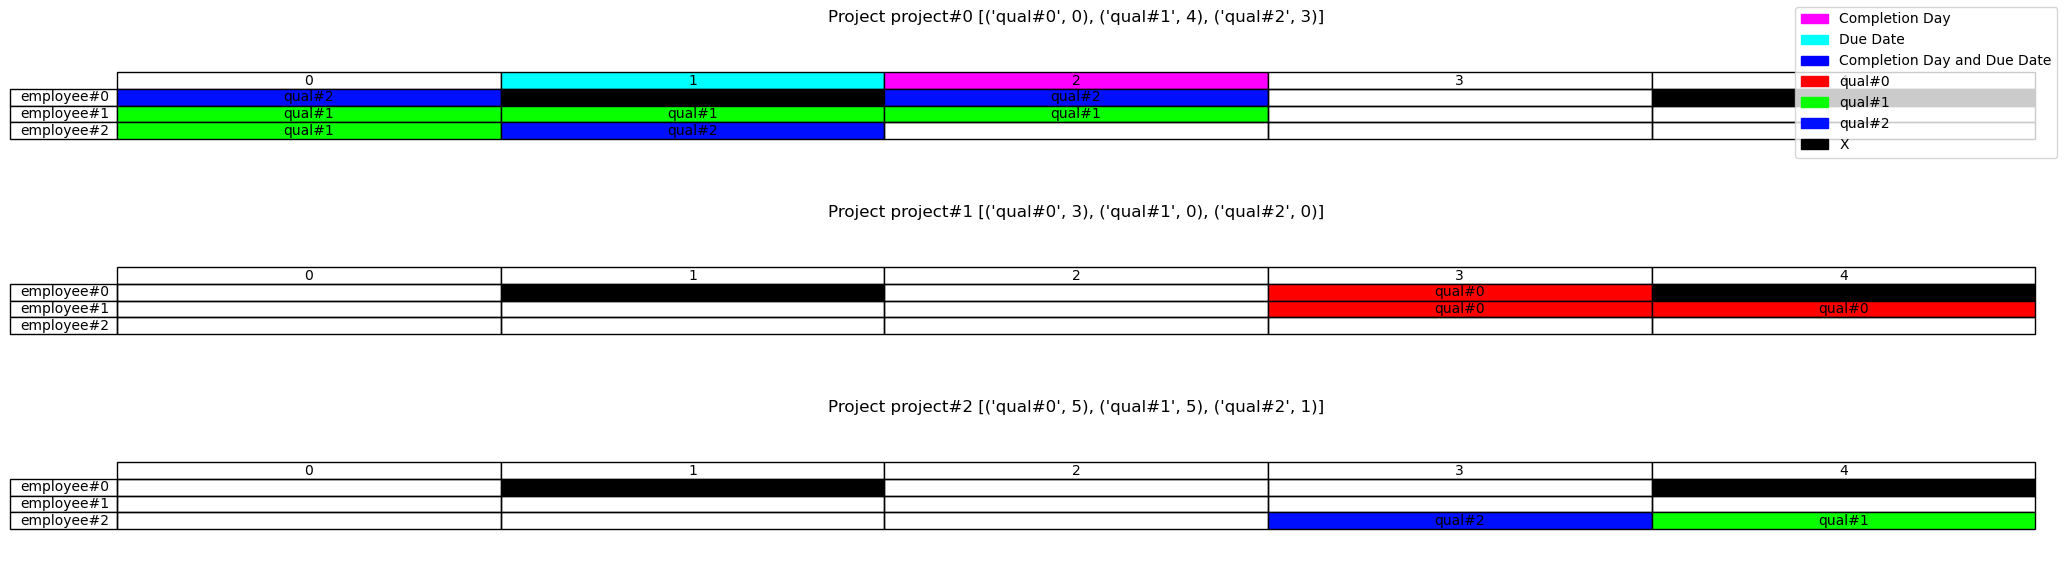

In [672]:
plot: Ploter = Ploter(m)

plot.gantt_projects()

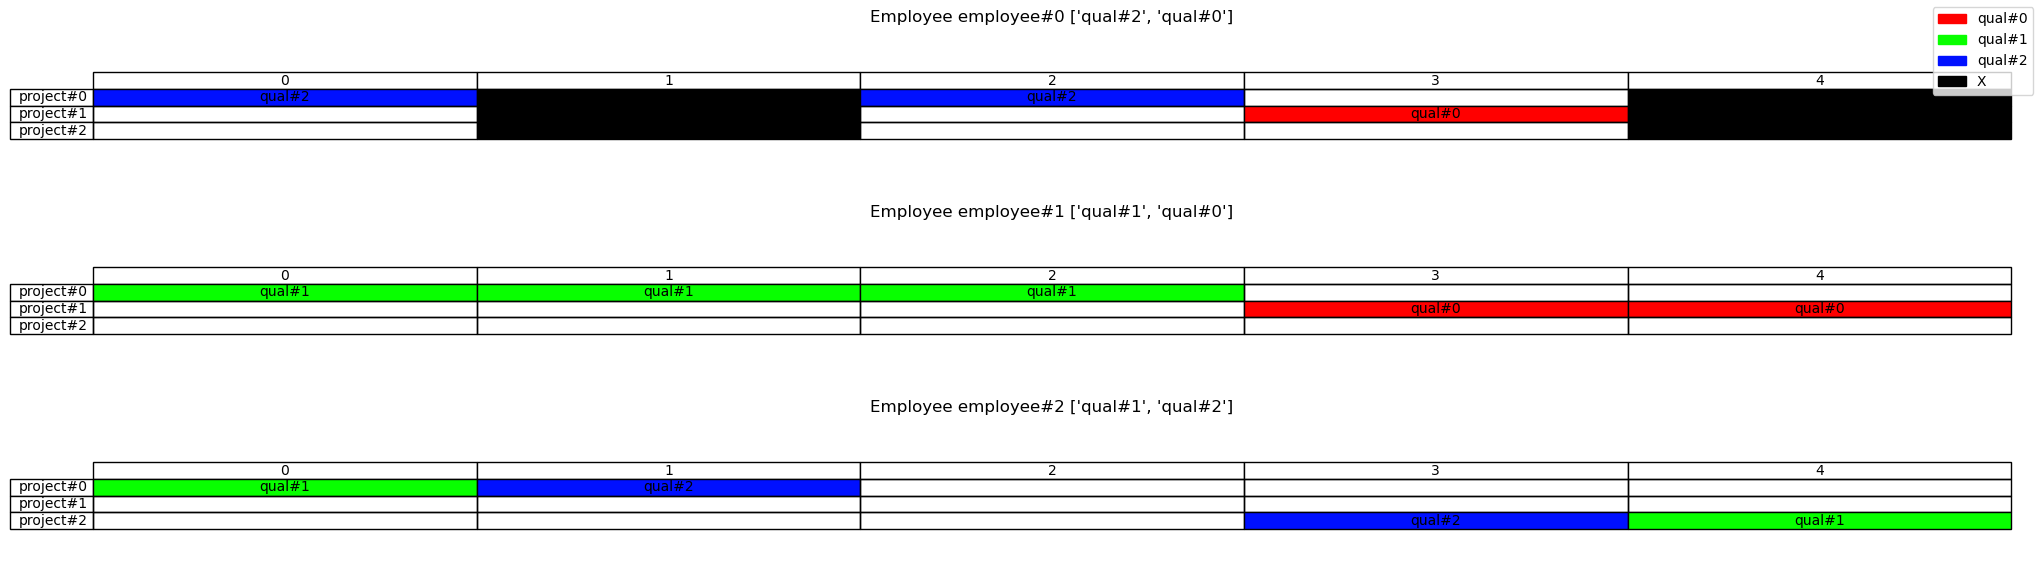

In [673]:
plot.gantt_employees()